#### Контрольные вопросы (1 балл)

1. что такое порядок точности метода?
Ответ: степень h в старшем члене ошибки

2. какой порядок метода будет при численном дифференцировании по $N$ узлам и почему?
Ответ: N-1, мы получаем уравнения на коээфициенты 

3. как называется матрица СЛАУ на коэффициенты метода неопределенных коэффицентов? Существует ли единственное решение системы и почему?
Ответ: матрица Вандермонта, у нее детерминант не ноль, когда все узлы разные


In [87]:
#скрипт, который реализует алгоритм метода неопределенных коэффициентов
import numpy as np
import numpy.linalg as la

def get_diff(u, l, m, h):
    n = u.size
    v = np.linspace(-l,m, n)
    # формируем матрицу системы в нужном виде
    A = np.fliplr(np.vander(v, v.size)).T 
    b = np.zeros(n)
    b[1] = 1
    alpha = la.solve(A,b)
    diff = 1/h*alpha.dot(u.T)
    return diff

p = 4 # порядок метода
a = np.pi/3
b = np.pi/2
h = (b-a)/p
print('h = ', h)
x = np.linspace(a, b, p+1)
u = np.sin(x) #ищем производную синуса

diff = get_diff(u, 0, p, h)
print('diff = ', diff)

h =  0.13089969389957473
diff =  0.4999823898925273


## Часть 1. Ошибка и обусловленность МНК (1 балл)

Задание:

1. написать скрипт, который строит график зависимости абсолютной ошибки от числа узлов. Используйте логарифмический масштаб, разумное число узлов. Обратите внимание, что сначала ошибка убывает, затем растет. Объясните почему.
2. Написать скрипт, который строит график зависимости числа обусловленности матрицы A системы с ростом ее размерности. Используйте логарифмический масштаб. Объясните поведение графика.

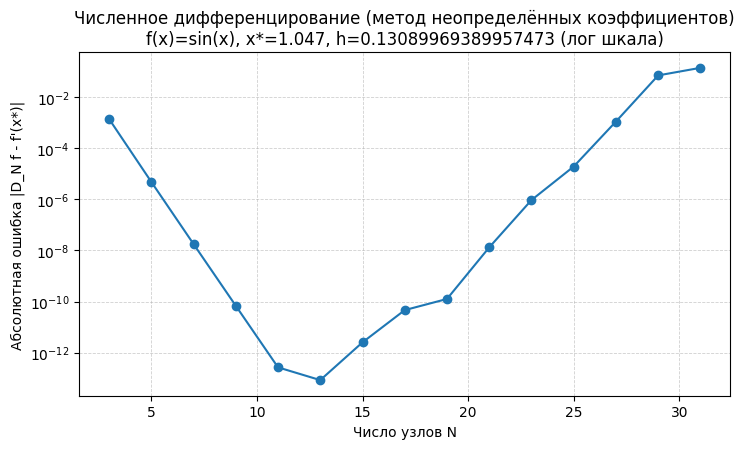

Почему кривая сначала падает, а потом растёт:
1) Аппроксимационная ошибка убывает с ростом N (~ h^(N-1)): мы "убиваем" всё больше членов разложения Тейлора.
2) Но веса становятся большими и разнонаправленными → усиливают округление/шум.
   Поэтому после некоторого N* доминирует численная ошибка, и график идёт вверх.


In [88]:
# first task
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

class InputData:
    def __init__(self, function, functions_derivate,  x0: float, h: float, left_border: int, right_border: int):
        self.function = function
        self.actual_derivate = functions_derivate
        self.x0 = x0
        self.h = h
        self.Ns = list(range(left_border, right_border, 2))
        self.actual_derivate_at_x0 = functions_derivate(self.x0)

    def fill_errors(self) -> None:
        errors = []
        for N in self.Ns:
            l = m = (N - 1) // 2        # so we have symmetric nodes(like: 1, 0, -1)                 
            shifts = np.arange(-l, m+1) #
            x_nodes = self.x0 + shifts * h                 
            u_vals = self.function(x_nodes)                    
            approx = get_diff(u_vals, l, m, h)       
            errors.append(abs(approx - self.actual_derivate_at_x0))

        self.errors = np.array(errors)


def plot_graphic(data: InputData) -> None:
    if data.errors is None:
        raise RuntimeError("error is empty, first call data.fill_errors()")
    
    plt.figure(figsize=(7.5, 4.6))
    plt.semilogy(data.Ns, data.errors, marker='o')
    plt.xlabel('Число узлов N')
    plt.ylabel('Абсолютная ошибка |D_N f - f\'(x*)|')
    plt.title('Численное дифференцирование (метод неопределённых коэффициентов)\n'
            f'f(x)=sin(x), x*={data.x0:.3f}, h={h} (лог шкала)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
    plt.tight_layout()
    plt.show()

def print_explanation() -> None:
    print("Почему кривая сначала падает, а потом растёт:")
    print("1) Аппроксимационная ошибка убывает с ростом N (~ h^(N-1)): "
        "мы \"убиваем\" всё больше членов разложения Тейлора.")
    print("2) Но веса становятся большими и разнонаправленными → усиливают округление/шум.")
    print("   Поэтому после некоторого N* доминирует численная ошибка, и график идёт вверх.")

if __name__ == "__main__":
    data = InputData(
        function=np.sin,
        functions_derivate=np.cos,
        x0=np.pi/3,
        h=1e-1,
        left_border=3,
        right_border=33,
    )
    data.fill_errors()
    plot_graphic(data)

    print_explanation()

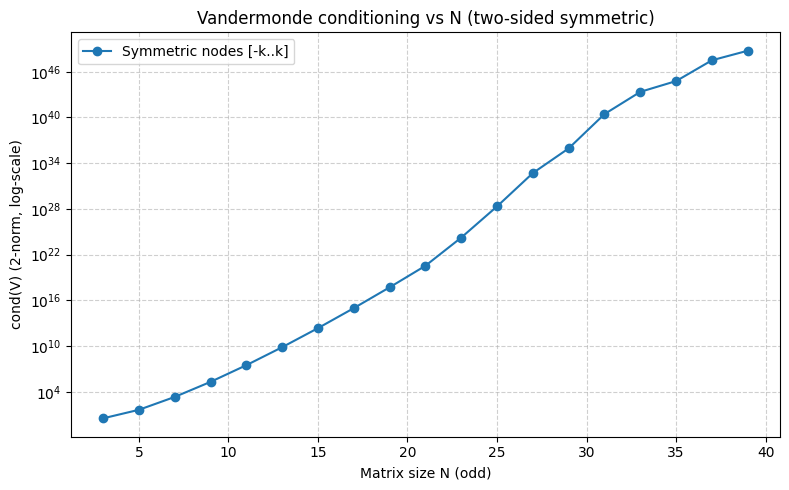

Почему cond(V) растёт с N (двусторонние симметричные узлы):
• Столбцы [1, t, t^2, ...] становятся численно почти линейно зависимыми.
• Разлёт масштабов растёт (очень маленькие и очень большие числа в одной матрице).
• Поэтому малые возмущения/округления сильно усиливаются -> cond(V) быстро растёт.


In [75]:
# task 2: condition number of Vandermonde 

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

class ConditionNumber:
    def __init__(self, left_border: int, right_border: int):
        # odd sizes: 3,5,7,... up to right_border-1
        self.Ns = list(range(left_border, right_border, 2))

    @staticmethod
    def symmetric_shifts(N: int) -> np.ndarray:
        """Nodes: [-k, ..., 0, ..., +k], N must be odd (N=2k+1)."""
        if N % 2 == 0:
            raise ValueError("N must be odd for symmetric two-sided nodes.")
        k = (N - 1) // 2
        return np.arange(-k, k + 1, dtype=float)

    @staticmethod
    def vander_from_shifts(shifts: np.ndarray) -> np.ndarray:
        """Rows are powers 0..N-1 (transpose of standard Vandermonde)."""
        N = shifts.size
        return np.vstack([shifts**s for s in range(N)])

    def cond_curve(self) -> list[float]:
        """cond_2(V) for each N in self.Ns (symmetric nodes)."""
        vals: list[float] = []
        for N in self.Ns:
            shifts = self.symmetric_shifts(N)
            V = self.vander_from_shifts(shifts)
            vals.append(la.cond(V, p=2))
        return vals

def plot_cond(Ns: list[int], conds: list[float]) -> None:
    """Plot cond(V) vs N in log-scale (y)."""
    plt.figure(figsize=(8, 5))
    plt.semilogy(Ns, conds, marker='o', label='Symmetric nodes [-k..k]')
    plt.xlabel("Matrix size N (odd)")
    plt.ylabel("cond(V) (2-norm, log-scale)")
    plt.title("Vandermonde conditioning vs N (two-sided symmetric)")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def explain_behavior() -> None:
    print("Почему cond(V) растёт с N (двусторонние симметричные узлы):")
    print("• Столбцы [1, t, t^2, ...] становятся численно почти линейно зависимыми.")
    print("• Разлёт масштабов растёт (очень маленькие и очень большие числа в одной матрице).")
    print("• Поэтому малые возмущения/округления сильно усиливаются -> cond(V) быстро растёт.")

def main() -> None:
    numbers = ConditionNumber(3, 41)
    conds = numbers.cond_curve()
    plot_cond(numbers.Ns, conds)
    explain_behavior()

if __name__ == "__main__":
    main()

## Часть 2. Оценка порядка точности метода (2 балла)

Рассмотрим метод с порядком точности $p$. Тогда ошибка метода $\epsilon_h = Ch^p$, где $h$ - сеточный шаг. На сетке с двое меньшим шагом ошибка метода будет $\epsilon_{h/2} = C_1 \left(\frac{h}{2}\right)^p$. Если шаг h достаточно мелкий (ф-я меняется не очень сильно), то можно считать, что $C \approx C_1$. Тогда, исключив $C$ из первого равенства за счет второго, можно получить, что
$$
p = \log_2 \frac{\epsilon_h}{\epsilon_{h/2}}
$$

Задание:

3. написать скрипт, который численно будет определять порядок точности методов направленная разность и центральная разность. Построить график зависимости p от шага сетки в широком диапазоне значений h. На графике для h использовать логарифмический масштаб. Объяснить поведение графиков. Исследуйте при это области как слева, так и справа от плато. Почему положения плато отличаются для двух методов и находятся именно на своих уровнях (обосновать аналитически).

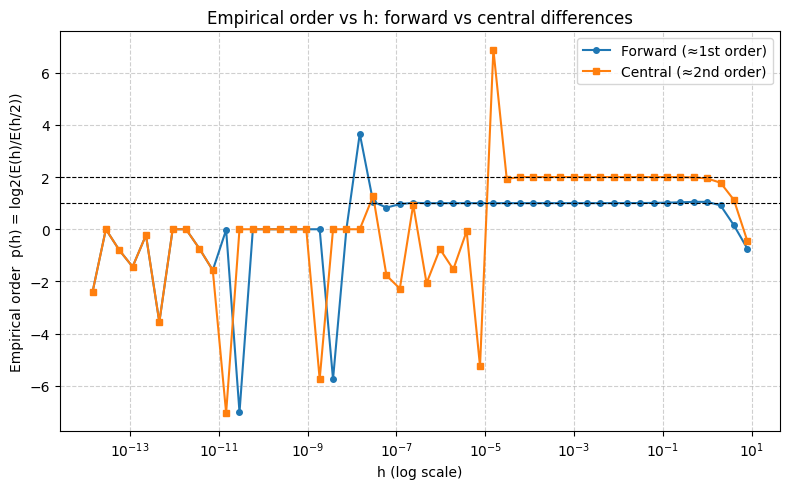


    1) Что считаем: p(h) = log2(E(h)/E(h/2)), где E(h) — абсолютная ошибка.
    2) Почему плато:
       – Для forward-разности ошибка ~ h → p ≈ 1.
       – Для central-разности ошибка ~ h^2 → p ≈ 2.
    3) слева выбивается, тк в следствии ошибок округления на машине, справа из за большого h
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class EmpiricalOrder:
    def __init__(self, f, df, x0: float, h0: float = 1.0, halvings: int = 40):
        """
        f, df : function and exact derivative
        x0    : evaluation point
        h0    : starting step (largest h), the grid will be h_k = h0 / 2^k
        halvings : number of halvings -> controls smallest h
        """
        self.f = f
        self.df = df
        self.x0 = float(x0)
        self.h0 = float(h0)
        self.K = int(halvings)
        # dyadic grid of steps: h_k = h0 / 2^k, k=0..K
        self.hs = self.h0 / (2.0 ** np.arange(self.K + 1))
        self.true = float(self.df(self.x0))

    @staticmethod
    def forward_diff(f, x, h):
        """Forward difference: O(h)."""
        return (f(x + h) - f(x)) / h

    @staticmethod
    def central_diff(f, x, h):
        """Central difference: O(h^2)."""
        return (f(x + h) - f(x - h)) / (2.0 * h)

    def errors(self, scheme: str) -> np.ndarray:
        """Absolute errors E(h) for all hs, given a scheme ('forward'|'central')."""
        if scheme == "forward":
            approx = np.array([self.forward_diff(self.f, self.x0, h) for h in self.hs])
        elif scheme == "central":
            approx = np.array([self.central_diff(self.f, self.x0, h) for h in self.hs])
        else:
            raise ValueError("scheme must be 'forward' or 'central'")
        return np.abs(approx - self.true)

    @staticmethod
    def empirical_p(hs: np.ndarray, errs: np.ndarray):
        """
        Return (hk, pk) where hk = hs[:-1], pk = log2( E(h)/E(h/2) ).
        Assumes hs is dyadic: h_{k+1} = h_k / 2.
        """
        Ek = errs[:-1]
        Ek2 = errs[1:]
        pk = np.log2(Ek / Ek2)
        hk = hs[:-1]
        return hk, pk

    def plot_orders(self):
        """Plot p(h) for both schemes on the same figure (log-scale in h)."""
        err_f = self.errors("forward")
        err_c = self.errors("central")
        h_f, p_f = self.empirical_p(self.hs, err_f)
        h_c, p_c = self.empirical_p(self.hs, err_c)

        plt.figure(figsize=(8, 5))
        plt.semilogx(h_f, p_f, marker='o', ms=4, label="Forward (≈1st order)")
        plt.semilogx(h_c, p_c, marker='s', ms=4, label="Central (≈2nd order)")
        plt.axhline(1.0, color='k', linestyle='--', linewidth=0.8)
        plt.axhline(2.0, color='k', linestyle='--', linewidth=0.8)
        plt.xlabel("h (log scale)")
        plt.ylabel("Empirical order  p(h) = log2(E(h)/E(h/2))")
        plt.title("Empirical order vs h: forward vs central differences")
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

def explain_behavior():
    explonation = """
    1) Что считаем: p(h) = log2(E(h)/E(h/2)), где E(h) — абсолютная ошибка.
    2) Почему плато:
       – Для forward-разности ошибка ~ h → p ≈ 1.
       – Для central-разности ошибка ~ h^2 → p ≈ 2.
    3) слева выбивается, тк в следствии ошибок округления на машине, справа из за большого h
    """
    print(explonation)

if __name__ == "__main__":
    f  = np.sin
    df = np.cos
    x0 = 1.0
    est = EmpiricalOrder(f, df, x0=x0, h0=8.0, halvings=50)
    est.plot_orders()
    explain_behavior()

## Часть $3$. Дифференцирование с использованием полиномиальной интерполяции (2 балла)

Предложите вариант решения задачи численного дифференцирования на основании метода полиномиальной интерполяции по известным значениям функции. Реализуйте алгоритм, сравните его с МНК. Что общего у методов?

In [ ]:
import numpy as np
import numpy.linalg as la

def get_diff(u, l, m, h):
    n = u.size
    v = np.linspace(-l,m, n)
    A = np.fliplr(np.vander(v, v.size)).T 
    b = np.zeros(n)
    b[1] = 1
    alpha = la.solve(A,b)
    diff = 1/h*alpha.dot(u.T)
    return diff

def derivative_lagrange(x, y, x0):
    """
    Compute P'(x0) where P(x)=sum_i y_i L_i(x), L_i are Lagrange basis.
    Direct formula: P'(x0)=sum_i y_i * L_i'(x0).
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = x.size

    denom = np.ones(n, dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                denom[i] *= (x[i] - x[j])

    Lp = np.zeros(n, dtype=float)
    for i in range(n):
        s = 0.0
        for k in range(n):
            if k == i: 
                continue
            term = 1.0 / (x[i] - x[k])
            for j in range(n):
                if j == i or j == k:
                    continue
                term *= (x0 - x[j]) / (x[i] - x[j])
            s += term
        Lp[i] = s
    return float(np.dot(y, Lp))

if __name__ == "__main__":
    f, df = np.sin, np.cos

    p = 4                       
    a = np.pi/3
    b = np.pi/2
    h = (b - a) / p
    print("h =", h)

    x = np.linspace(a, b, p+1)   
    u = f(x)
    x0 = a                       

    diff_uc  = get_diff(u, l=0, m=p, h=h)        
    diff_lag = derivative_lagrange(x, u, x0)    
    true     = df(x0)

    print(f"x0 = {x0:.6f}")
    print(f"истинное значение        = {true:.12f}")
    print(f"неопр. коэффициенты      = {diff_uc:.12f}   погр={abs(diff_uc-true):.3e}")
    print(f"Лагранж (интерп.)        = {diff_lag:.12f}  погр={abs(diff_lag-true):.3e}")
    print(f"|Лагранж - неопр.|       = {abs(diff_lag-diff_uc):.3e}")


h = 0.13089969389957473
x0 = 1.047198
истинное значение        = 0.500000000000
неопр. коэффициенты      = 0.499982389893   погр=1.761e-05
Лагранж (интерп.)        = 0.499982389893  погр=1.761e-05
|Лагранж - неопр.|       = 4.441e-15


## Часть 4. Пример проблемы использования метода Гаусса для решения СЛАУ (2 балл)

Перед вами простая реализация метода Гаусса для решения СЛАУ. Далее по коду представлены две СЛАУ $A_1x = b_1$ и $A_2x = b_2$, эквивалентные с точностью до перестановки строк. ЗАДАНИЕ: необходимо объяснить, почему для представленного метода Гаусса решения различаются.

In [48]:
import numpy as np
import copy 

def gauss( A_in, b_in ):
    n = b_in.size
    A = copy.deepcopy(A_in)
    b = copy.deepcopy(b_in)
    for k in range(0,n-1):
        for i in range(k+1,n): 
            if A[i,k]!=0:
                c = A[i,k]/A[k,k]
                A[i,k+1:n] = A[i,k+1:n] - c*A[k,k+1:n]
                b[i] = b[i] - c*b[k]
                
    # обратный ход
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(A[k,k+1:n],b[k+1:n]))/A[k,k]
    return b

In [49]:
A1 = np.array([[1e-16, 1.,   -1.], 
               [-1.,   2.,   -1.], 
               [2.,   -1.,    0.]])

b1 = np.array([0., 0., 1.])

A2 = np.array([[2.,   -1.,   0.], 
               [-1.,   2.,  -1.], 
               [1e-16, 1.,  -1.]])

b2 = np.array([1., 0., 0.])

print('u1 = ', gauss(A1, b1))
print('u2 = ', gauss(A2, b2))

u1 =  [0.55511151 0.25       0.25      ]
u2 =  [1. 1. 1.]


## Ответ:
в A1 элемент (1,1) очень мал, и при делении `c = A[i,k]/A[k,k]` получается умножение на 10^16, и тогда из за арифметики

```python
    A[i,k+1:n] = A[i,k+1:n] - c*A[k,k+1:n]
    b[i] = b[i] - c*b[k]
```
Происходит большая потеря значащих цифр

Модифицировать метод Гаусса так, чтобы система $A_1x = b_1$ решалась корректно. ВАЖНО: реализация метода должна быть получена путем модификации метода gauss, а не переписыванием кода с нуля! 

In [51]:
import numpy as np
import copy

def gauss(A_in, b_in):
    n = b_in.size
    A = copy.deepcopy(A_in)
    b = copy.deepcopy(b_in)

    for k in range(0, n-1):
        # --- main idea: we choose the largest pivot ---
        # --- NEW: partial pivoting (choose best row for the k-th pivot) ---
        p = k + np.argmax(np.abs(A[k:n, k]))  # index of max |A[i,k]| for i>=k
        if A[p, k] == 0:
            raise ZeroDivisionError("Matrix is singular or nearly singular at column {}".format(k))
        if p != k:
            # swap rows k and p in A and b
            A[[k, p], k:n] = A[[p, k], k:n]
            b[[k, p]] = b[[p, k]]
        # -------------------------------------------------------------------

        for i in range(k+1, n):
            if A[i, k] != 0:
                c = A[i, k] / A[k, k]
                A[i, k+1:n] = A[i, k+1:n] - c * A[k, k+1:n]
                b[i] = b[i] - c * b[k]

    # обратный ход
    for k in range(n-1, -1, -1):
        b[k] = (b[k] - np.dot(A[k, k+1:n], b[k+1:n])) / A[k, k]
    return b

if __name__ == "__main__":
    A1 = np.array([[1e-16, 1., -1.], 
                [-1., 2., -1.], 
                [2., -1., 0.]])

    b1 = np.array([0., 0., 1.])

    A2 = np.array([[2., -1., 0.], 
                [-1., 2., -1.], 
                [1e-16, 1., -1.]])

    b2 = np.array([1., 0., 0.])

    print('u1 = ', gauss(A1, b1))
    print('u2 = ', gauss(A2, b2))

u1 =  [1. 1. 1.]
u2 =  [1. 1. 1.]


## Часть 5. LU разложение (1 балл)

Задание: 

реализовать алгоритм решения предыдущей задачи с матрицей A2 с помощью LU-разложение В решении должна выводиться L, U и собственно решение системы. 

ВАЖНО: реализация метода LU должна быть получена путем небольшой модификации метода gauss!  При это саму реализацию можно разделить на два метода: один метод собственно находит LU разложение (можно сделать переделкой цикла для матрицы A метода gauss), второй метод - непосредственное решение системы с помощью прямого и обратного хода. Ни в каком виде нельзя пользоваться пакетными методами (в частности, la.solve)

In [ ]:
import numpy as np
import copy
import sympy as sp

def LU( A_in, b_in):
    n = b_in.size
    L = np.eye(n)
    U = np.zeros((n, n))
    A = copy.deepcopy(A_in)
    b = copy.deepcopy(b_in)
    for k in range(n):
        for j in range(k, n):
            U[k, j] = A[k, j] - np.dot(L[k, :k], U[:k, j])
        
        for i in range(k + 1, n):
            L[i, k] = (A[i, k] - np.dot(L[i, :k], U[:k, k])) / U[k, k]
    

    y = np.zeros_like(b)
    x = np.zeros_like(y)
    for k in range(n):
        y[k] = (b[k] - np.dot(L[k, :k], y[:k])) / L[k, k]
    for k in range(n-1, -1, -1):
        x[k] = (y[k] - np.dot(U[k, k+1:n], x[k+1:n])) / U[k, k]
    return L, U, x


def spprint(name, M):
    print(f"{name} =")
    display(sp.Matrix(M)) 
    print()
    
if __name__ == "__main__":

    A2 = np.array([[ 2., -1.,  0.],
                [-1.,  2., -1.],
                [ 1e-16, 1., -1.]])
    b2 = np.array([1., 0., 0.])

    L, U, x = LU(A2, b2)


    spprint("L", L)
    spprint("U", U)
    spprint("x", x.reshape(-1,1)) 
    print("residual ||Ax-b|| =", np.linalg.norm(A2@x - b2))

L =


Matrix([
[    1.0,               0.0, 0.0],
[   -0.5,               1.0, 0.0],
[5.0e-17, 0.666666666666667, 1.0]])


U =


Matrix([
[2.0, -1.0,                0.0],
[0.0,  1.5,               -1.0],
[0.0,  0.0, -0.333333333333333]])


x =


Matrix([
[1.0],
[1.0],
[1.0]])


residual ||Ax-b|| = 0.0


## Часть 6. Нахождение обратной матрицы с помощью LU разложения (1 балл)

Задание:

Предложить алгоритм с использованием LU-разложения и найти обратную матрицу с точностью $\epsilon = 10^{-3}$:
$$
A = \begin{pmatrix} 
1 & 1  & 1 \\
0 & 1 & 2 \\
7 & 1 & 4 \\
\end{pmatrix}
$$
Для необходимых оценок использовать первую норму. Сравнить результат со значением, найденным с помощью функции numpy.linalg.inv.

1. **LU-разложение:**  
   Матрица \(A\) представляется в виде \(A = L\,U\),  
   где \(L\) — нижнетреугольная (с единицами на диагонали),  
   а \(U\) — верхнетреугольная.  
   Это аналог прямого хода метода Гаусса.

2. **Инвертирование:**  
   - \(L^{-1}\) вычисляется прямым ходом (снизу вверх),  
   - \(U^{-1}\) — обратным ходом (сверху вниз).

3. **Обратная матрица:**  
   Из \((L\,U)^{-1} = U^{-1} L^{-1}\)  
   следует, что \(A^{-1} = U^{-1} L^{-1}\).

In [83]:
import numpy as np
import copy
import sympy as sp


def lu_factor(A_in):
    A = copy.deepcopy(A_in).astype(float)
    n = A.shape[0]
    L = np.eye(n)
    U = np.zeros((n, n))
    for k in range(n):
        for j in range(k, n):                     
            U[k, j] = A[k, j] - np.dot(L[k, :k], U[:k, j])
        if U[k, k] == 0.0:
            raise ZeroDivisionError(f"Zero pivot at k={k} (нужен pivoting).")
        for i in range(k + 1, n):                
            L[i, k] = (A[i, k] - np.dot(L[i, :k], U[:k, k])) / U[k, k]
    return L, U


def inv_unit_lower(L):
    n = L.shape[0]
    Linv = np.eye(n)
    for i in range(n):
        for j in range(i):                     
            Linv[i, j] = -np.dot(L[i, j:i], Linv[j:i, j])
    return Linv

def inv_upper(U):
    n = U.shape[0]
    Uinv = np.zeros((n, n))
    for i in range(n-1, -1, -1):
        Uinv[i, i] = 1.0 / U[i, i]
        for j in range(i-1, -1, -1):              
            s = np.dot(U[j, j+1:i+1], Uinv[j+1:i+1, i])
            Uinv[j, i] = -(s) / U[j, j]
    return Uinv

def inv_via_lu_closed_form(A):
    L, U = lu_factor(A)
    Linv = inv_unit_lower(L)
    Uinv = inv_upper(U)
    return Uinv @ Linv

def spprint(name, M):
    print(f"{name} =")
    display(sp.Matrix(M)) 
    print()
    
if __name__ == "__main__":
    A = np.array([[1.,1.,1.],
                [0.,1.,2.],
                [7.,1.,4.]], dtype=float)

    Ainv = inv_via_lu_closed_form(A)
    spprint("A^{-1}", Ainv)
    print("||I - A@Ainv||_1 =", np.linalg.norm(np.eye(3)-A@Ainv, 1))

    Ainv_np = np.linalg.inv(A)
    print("||Ainv - inv(A)||_1 =", np.linalg.norm(Ainv - Ainv_np, 1))

A^{-1} =


Matrix([
[ 0.222222222222222, -0.333333333333333,  0.111111111111111],
[  1.55555555555556, -0.333333333333333, -0.222222222222222],
[-0.777777777777778,  0.666666666666667,  0.111111111111111]])


||I - A@Ainv||_1 = 4.440892098500626e-16
||Ainv - inv(A)||_1 = 1.1102230246251565e-16
